In [2]:
# 0) Setup & import (fix path to src/)
import os, sys, json
from pathlib import Path

# Detect repo root even if the notebook runs from /notebooks
CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD
SRC_PATH = REPO_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

# now this works
from config import ROOT, DATA_RAW, DATA_PROCESSED, SPLIT_INFO, DATE_COL, LEVEL_COL, TARGET_COL

pd.set_option("display.precision", 6)
print("CWD:", CWD)
print("REPO_ROOT:", REPO_ROOT)
print("SRC_PATH in sys.path?", str(SRC_PATH) in sys.path)


CWD: /Users/samuele/Desktop/m2-forecast/notebooks
REPO_ROOT: /Users/samuele/Desktop/m2-forecast
SRC_PATH in sys.path? True


In [3]:
raw = pd.read_csv(DATA_RAW)
raw[DATE_COL] = pd.to_datetime(raw[DATE_COL])
raw = raw.set_index(DATE_COL).sort_index()

proc = pd.read_parquet(DATA_PROCESSED)  # contains LOG_COL and TARGET_COL
proc.index = pd.to_datetime(proc.index)

with open(SPLIT_INFO) as f:
    split = json.load(f)

n, n_test, cut = split["n_obs"], split["n_test"], split["cut_index"]

print("Raw:", raw.shape, "| Proc:", proc.shape)
print(f"Period: {proc.index.min().date()} → {proc.index.max().date()}")
print(f"Train length: {cut} | Test length: {n_test} (≈{int(100*split['test_fraction'])}%)")

proc[[TARGET_COL]].describe()


Raw: (801, 1) | Proc: (800, 3)
Period: 1959-02-01 → 2025-09-01
Train length: 640 | Test length: 160 (≈20%)


,g
count,800.000000
mean,0.543790
std,0.456674
min,-1.466482
25%,0.313940
50%,0.523172
75%,0.725978
max,6.135480


In [4]:
print("Missing raw:", raw.isna().sum().to_dict())
print("Missing proc:", proc.isna().sum().to_dict())

# Safety: positive level for log
non_pos = (raw[LEVEL_COL] <= 0).sum()
print("Non-positive M2SL rows:", int(non_pos))


Missing raw: {'M2SL': 0}
Missing proc: {'M2SL': 0, 'M2_log': 0, 'g': 0}
Non-positive M2SL rows: 0


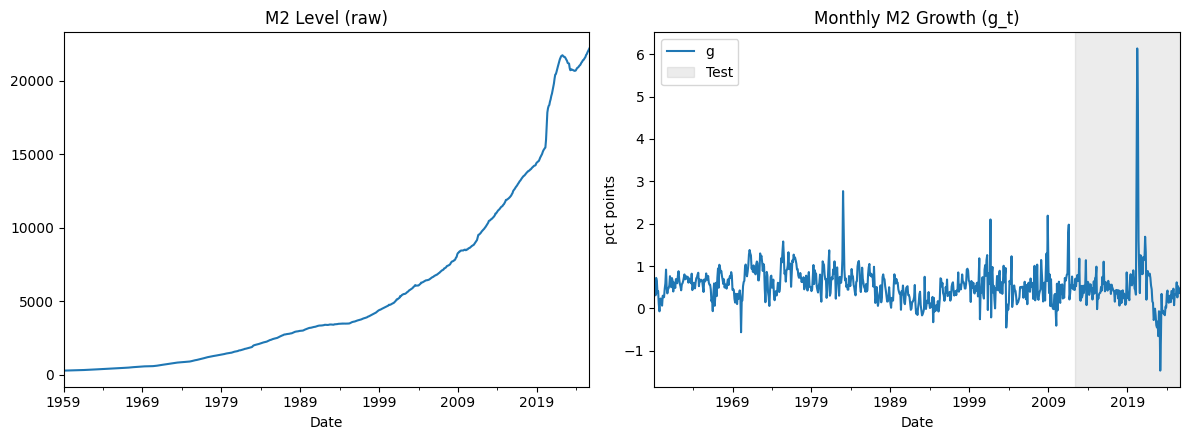

In [5]:
cut_date = proc.index[cut]

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
raw[LEVEL_COL].plot(ax=ax[0], title="M2 Level (raw)")
ax[0].set_xlabel("Date")

proc[TARGET_COL].plot(ax=ax[1], title="Monthly M2 Growth (g_t)")
ax[1].axvspan(cut_date, proc.index.max(), color="grey", alpha=0.15, label="Test")
ax[1].legend(loc="best")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("pct points")
plt.tight_layout()
plt.show()


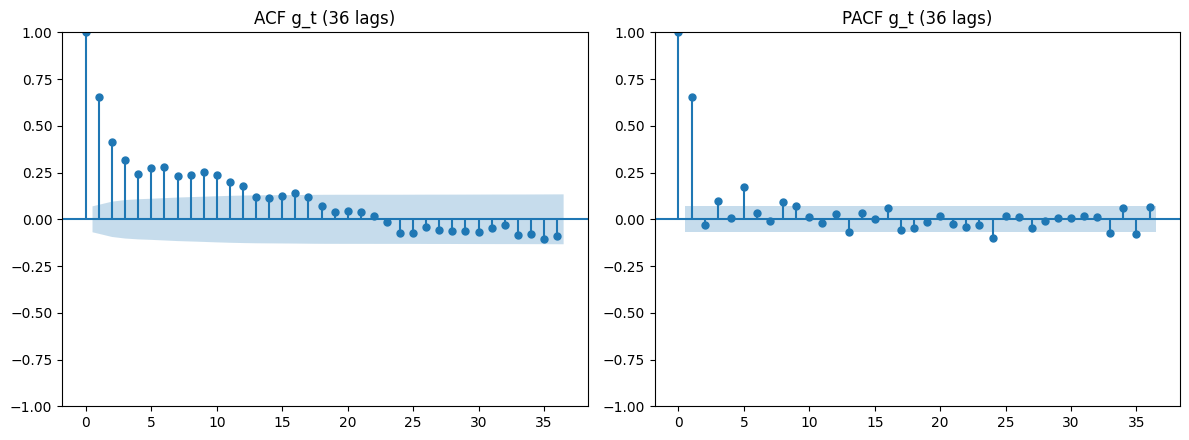

In [7]:
fig = plt.figure(figsize=(12, 4.5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
plot_acf(proc[TARGET_COL], lags=36, ax=ax1)
plot_pacf(proc[TARGET_COL], lags=36, ax=ax2, method="ywm")
ax1.set_title("ACF g_t (36 lags)")
ax2.set_title("PACF g_t (36 lags)")
plt.tight_layout()
plt.show()


In [8]:
g = proc[TARGET_COL].dropna()

adf_stat, adf_p, _, _, adf_crit, _ = adfuller(g, autolag="AIC")
kpss_stat, kpss_p, _, kpss_crit = kpss(g, regression="c", nlags="auto")

print(f"ADF:  stat={adf_stat:.3f}, p={adf_p:.4f}, crit={adf_crit}")
print(f"KPSS: stat={kpss_stat:.3f}, p={kpss_p:.4f}, crit={kpss_crit}")

# Simple interpretation helpers:
def interp_adf(p): 
    return "reject unit root (stationary)" if p < 0.05 else "fail to reject unit root (non-stationary)"
def interp_kpss(p): 
    return "fail to reject stationarity" if p > 0.05 else "reject stationarity (non-stationary)"

print("ADF ->", interp_adf(adf_p))
print("KPSS ->", interp_kpss(kpss_p))


ADF:  stat=-5.488, p=0.0000, crit={'1%': -3.4386441190814265, '5%': -2.8652008302305316, '10%': -2.568719369407094}
KPSS: stat=0.392, p=0.0807, crit={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF -> reject unit root (stationary)
KPSS -> fail to reject stationarity


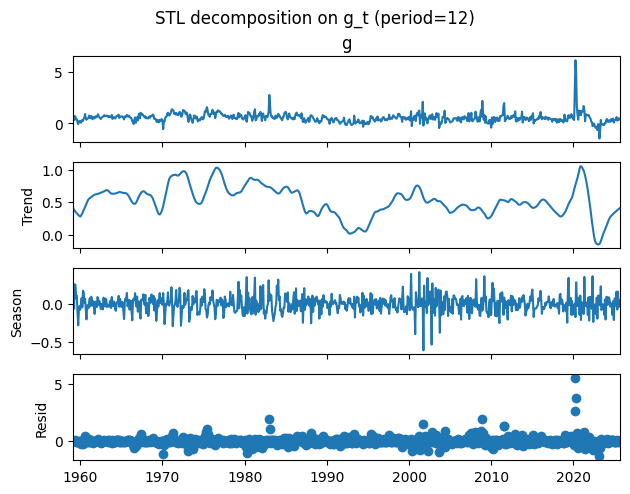

In [9]:
stl = STL(g, period=12, robust=True).fit()
stl.plot()
plt.suptitle("STL decomposition on g_t (period=12)", y=1.02)
plt.show()


Top 1% absolute spikes (dates):


observation_date
2020-04-01    6.135480
2020-05-01    4.863502
2020-03-01    3.349328
1983-01-01    2.768397
2008-12-01    2.189630
2001-09-01    2.100295
2011-08-01    1.977449
1983-02-01    1.890760
Name: g, dtype: float64

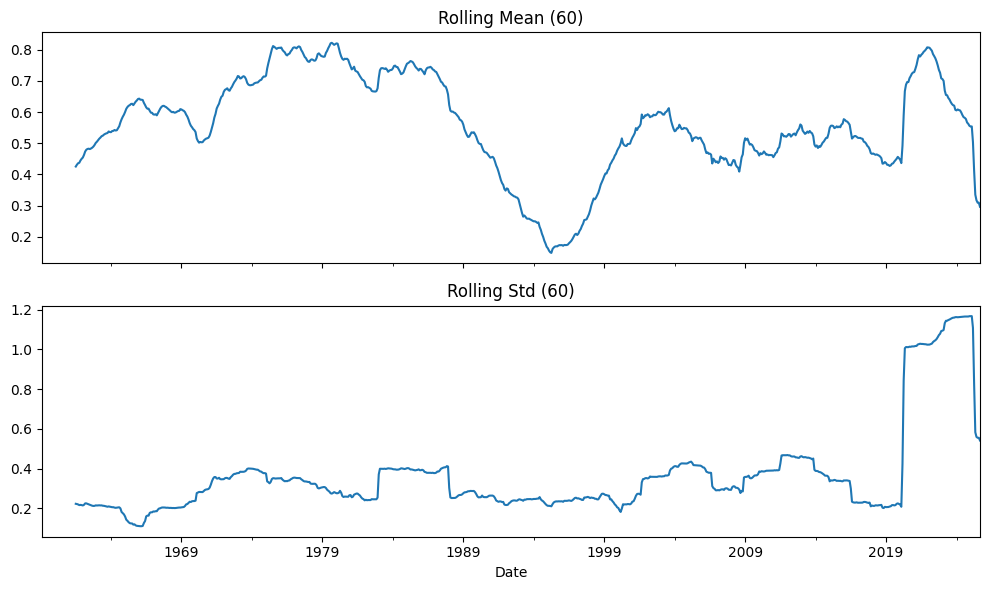

In [10]:
# Outliers (top 1% by absolute value)
thr = g.abs().quantile(0.99)
spikes = g[g.abs() >= thr]
print("Top 1% absolute spikes (dates):")
display(spikes.sort_values(ascending=False).head(10))

# Rolling mean/volatility (60 mesi)
roll = pd.DataFrame({
    "roll_mean_60": g.rolling(60, min_periods=30).mean(),
    "roll_std_60":  g.rolling(60, min_periods=30).std()
})
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
roll["roll_mean_60"].plot(ax=ax[0], title="Rolling Mean (60)")
roll["roll_std_60"].plot(ax=ax[1], title="Rolling Std (60)")
ax[1].set_xlabel("Date")
plt.tight_layout(); plt.show()
